# Run Qlasskit circuits in DQPU

In this notebook we show how to use DQPU to simulate a quantum circuit created using the qiskit library.

First, we import needed libraries, included the dqpu qiskit backend `DQPUBackend`.

In [1]:
from qiskit import QuantumCircuit, transpile
from dqpu.backends.qiskit import DQPUBackend

from qlasskit import qlassf, Qmatrix
from qlasskit.algorithms import Grover

Then we create a Grover search instance, searching for the solution of a 2x2 sudoku.

In [2]:
@qlassf
def sudoku_check(m: Qmatrix[bool, 2, 2]) -> bool:
    constr = m[0][0]
    sub0 = m[0][0] ^ m[0][1]
    sub1 = m[1][0] ^ m[1][1]
    sub2 = m[0][0] ^ m[1][0]
    sub3 = m[0][1] ^ m[1][1]
    return sub0 and sub1 and sub2 and sub3 and constr


qc = Grover(sudoku_check)
# qc.export().draw('mpl')

And now we instantiate the `DQPUBackend`; we also need to call `load_account` in order to load a NEAR wallet account created by near-cli (https://docs.near.org/tools/near-cli) using this command

```bash
near create-account ACCOUNT_NAME.testnet --useFaucet
```

In [3]:
backend = DQPUBackend()
backend.load_account("dqpu_alice.testnet")

asyncio.run() cannot be called from a running event loop


/home/dakk/.pyenv/versions/3.10.13/envs/dqpu2/lib/python3.10/site-packages/dqpu-0.2.1-py3.10.egg/dqpu/blockchain/near.py:68: RuntimeWarning: coroutine 'NearBlockchain.load_account.<locals>.v' was never awaited
  return loop.run_until_complete(v())


Now we transpile the circuit and we call the `run` method: this will send the quantum circuit along with a reward to the smart contract on the NEAR blockchain. Someone will simulate it for us, and a verifier will check for the result.

In [4]:
circ = transpile(qc.export(), backend)
job = backend.run(circ, shots=1024)

Calling `job.status()` we wait until the job turns into `EXECUTED` status.

In [5]:
print(job.status())

JobStatus.RUNNING


And finally we get the result from the smart contract and we plot it.

In [8]:
counts = job.result().get_counts(circ)
counts_readable = qc.decode_counts(counts, discard_lower=20)

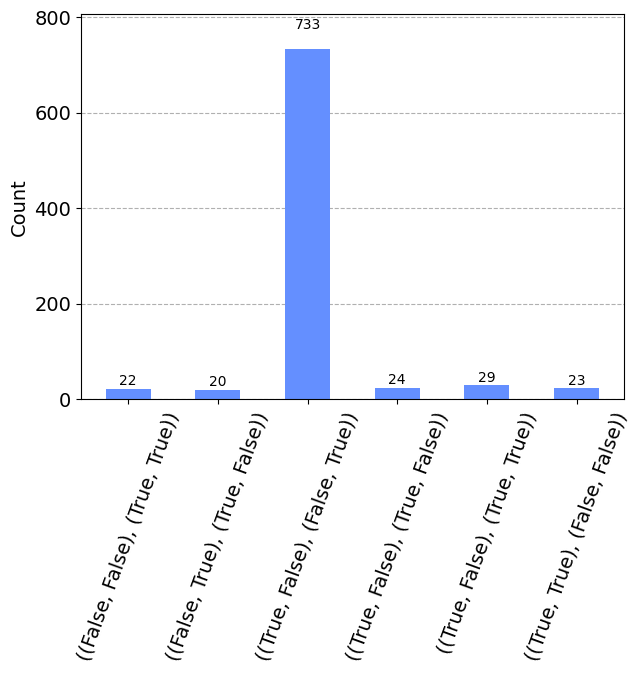

In [9]:
from qiskit.visualization import plot_histogram

plot_histogram(counts_readable)

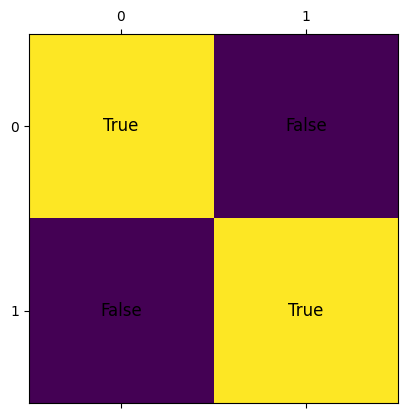

In [10]:
import matplotlib.pyplot as plt


def draw_matrix(matrix):
    fig, ax = plt.subplots()
    ax.matshow(matrix, cmap="viridis")

    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            ax.text(
                j,
                i,
                str(matrix[i][j]),
                va="center",
                ha="center",
                fontsize=12,
                color="black",
            )

    plt.show()


m_res = list(filter(lambda x: x[1] > 500, counts_readable.items()))[0][0]
draw_matrix(m_res)